#DQN, Function Approximation, Pefrormance tricks

In this lab we study the basics of Q learning with function approximation by neural networks.

In [33]:
# Installing dependencies for visualization
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install gym
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

E: Unable to locate package libcusparse8.0
E: Couldn't find any package by glob 'libcusparse8.0'
E: Couldn't find any package by regex 'libcusparse8.0'
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'


In [34]:
import glob
import random
import time


import gym
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.regularizers import l2
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, clone_model

import numpy as np
import matplotlib.pyplot as plt
import collections

from base64 import b64encode
from IPython.display import HTML
from pyvirtualdisplay import Display

# Start virtual display
display = Display(visible=0, size=(1024, 768))
display.start()

def show_video(file_name):
    mp4 = open(file_name,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=480 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

We will start by defining a useful data structure:

In [35]:
Transition = collections.namedtuple('transition', ['state', 'action', 'reward', 'done', 'next_state'])

## CartPole
Debugging DQN is typically a complicated process, thus we have to start with a simple environment, that can be quickly iterated. Let's first construct working DQN for CartPole problem. We will use a small modification of the orginal CartPole env, we do reward reshape (to make problem easier for DQN). Precisely, we add a punishment for ending the episode:

In [36]:
class ModifiedCartPole:
    def __init__(self):
        self.env = gym.make('CartPole-v0')

    def reset(self):
        return self.env.reset()

    def step(self, action):
        obs, reward, done, _ = self.env.step(action)
        if done:
            reward = -10
        return obs, reward/10, done, {}

##Q-network. 
First we must create a network to approximate Q(s, a). We have two natural design choices:
- Q-network takes two inputs: state s and action a and predicts one value Q(s,a)
- Q-network takes one input: state s, and predicts a vector of Q(s, a) for all possible actions.

We will follow the second design choice (one of the reasons is that such network can faster predict the best action).

**Exercise: fill the code below to create Q-network**. Create a simple fully connected network with num_layers layers each with 64 neurons. The input is a vector of size 4, and the output is a vector of size 2 (we have 2 actions in cartpole).

In [37]:
def make_cartpole_network(input_size=4, num_action=2, num_layers=3, learning_rate=1e-4, weight_decay=0.):
  input_state = Input(batch_shape=(None, input_size))
  x = input_state
  for _ in range(num_layers):
    x = Dense(64, activation='relu')(x)
  output = Dense(num_action)(x)
  model = Model(inputs=input_state, outputs=output)
  model.compile(
      loss='mse',
      optimizer=Adam(learning_rate=learning_rate)
  )
  return model

## Building DQN

We will start with some utils functions:

**Exercise: read the following functions, to understand them** (will be used later).

In [38]:
def predict_q_values(q_network, state):
  # Makes a prediction for a single state and returns array of Q-values
  return q_network.predict(np.array([state]))[0]

def choose_best_action(q_network, state):
  # Chooses best action according to Q-network
  action_values = predict_q_values(q_network, state)
  best_action = np.argmax(action_values)
  return best_action

def evaluate_state_batch(target_network, state_batch):
  '''This function can evaluate the whole batch of states at once, it
  is very useful to speedup the training when we calculate targets
  Arguments:
    - state_batch: list of states to evaluate
  Returns:
    - best actions: list of best action for every state
    - best vals: list of best state-action values for very state
    - action_values: list of all action-values for each state

  Here we named the argument target network instead of q_network, because this
  function will be used with target network.
  '''
  action_values = target_network.predict(np.array(state_batch))
  best_actions = np.argmax(action_values, axis=-1)
  best_vals = np.max(action_values, axis=-1)
  return best_actions, best_vals, action_values


def choose_action(q_network, state, epsilon):
  if random.random() < epsilon:
      return random.randint(0, 1)
  else:
      return choose_best_action(q_network, state)

While running the epizodes we will collect transitions and store them in a replay_buffer, which is just a list of transitions. Before we write a code for running epizodes we must first prepare a function that prepares training (since it is used while running the game) and a one for doing the training.

**Exercise: the training protocole is the heart of DQN. Fill the gaps in the following function**

In [39]:
def prepare_train_targets(target_network, replay_buffer, mini_batch_size, q_learning_rate=0.5, gamma=0.99):
  ''' Write a code to choose random samples from replay_buffer. 
  Choose mini_batch_size of samples and collect them in replay_batch. 
  Replay batch must be a list of transitions. '''

  #Hint: you can use random.sample method

  replay_batch = random.sample(replay_buffer, mini_batch_size)

  # We will collect all states and next_states from the batch of transitions to evaluate them at once
  # ( optimization!)
  next_state_batch = []
  state_batch = []
  train_x, train_y = [], []

  for transition in replay_batch:
    next_state_batch.append(transition.next_state)
    state_batch.append(transition.state)

  _, next_state_values, _ = evaluate_state_batch(target_network, next_state_batch)
  _, _, state_action_vals = evaluate_state_batch(target_network, state_batch)

  for transition, state_vals, next_state_value in zip(replay_batch, state_action_vals, next_state_values):
    action = transition.action
    
    ''' Create train datapoints'''
    # Copy transition.state to x, use copy() method
    x = transition.state.copy()
    ''' In out setting y must be a list of two values (Q-values for 2 actions).
    Note, that we want to update only of the y values (corresponding to chosen action)'''
    # Copy state_vals vector to y
    y = state_vals.copy()
    
    '''Calculate the target value for y[action]. Implement the Q-iteration formula:
    Q(s,a) <- q_learning_rate*(reward + gamma * max_a' Q_target(s', a')) + (1-q_learning_rate Q(s,a))
    Remember to separately treat the case where the transition is last in the epizode. 
    You can check if the transition is last, by looking at transition.done'''
    if not transition.done:
      y[action] = q_learning_rate * (transition.reward + gamma * next_state_value) + (1 - q_learning_rate * y[action])
    else:
      y[action] = q_learning_rate * transition.reward  + (1 - q_learning_rate * y[action])
    train_x.append(x)
    train_y.append(y)

  return np.array(train_x), np.array(train_y)

**Exercise: fill the gaps in the training function**

In [40]:
def train(q_network, target_network, replay_buffer, train_epochs, mini_batch_size, q_learning_rate, gamma):
  train_x, train_y =  prepare_train_targets(target_network, replay_buffer, mini_batch_size, q_learning_rate, gamma)
  '''For models in keras you can use fit() method that takes x and y as inputs and return history. 
      Hint: fit() method has verbose atribute that determines what this function prints on the screen 
      You can set verbose=0 to have no prints.'''
  #<YOUR CODE HERE> (here use keras.fit method)
  history = q_network.fit(train_x, train_y, verbose=0)
  return history.history['loss']

Now, let us code the heart of DQN algorithm: the function that runs an epizode and trains Q-network.

**Exercise: fill the code in run_one_episode function**

In [41]:
def run_one_episode(q_network, target_network, env, epsilon, steps_so_far, replay_buffer,
                    train_epochs, mini_batch_size, train_every_n_steps, update_target_every_n_steps,
                    q_learning_rate, gamma, replay_buffer_max):
    done = False
    episode_steps = 0
    state = env.reset()
    ep_actions = []
    loss_history = []
    while not done:
        #<YOUR CODE HERE>  (use choose_action function)
        action = choose_action(target_network, state, epsilon)
        ep_actions.append(action)
        next_state, reward, done, _ = env.step(action)
        episode_steps += 1
        steps_so_far += 1
        #<YOUR CODE HERE> use state, action, reward, done, next_state to create new transition 
        new_transition = Transition(state, action, reward, done, next_state)
        if replay_buffer_max is not None:
          if len(replay_buffer) > replay_buffer_max:
            last = replay_buffer.pop(0)
        replay_buffer.append(new_transition)

        state = next_state
        
        if steps_so_far % train_every_n_steps == 0 and len(replay_buffer) > mini_batch_size:
            #<YOUR CODE HERE> use the train function from above here to train q_network
            history = train(q_network, target_network, replay_buffer, train_epochs, mini_batch_size, q_learning_rate, gamma)
            loss_history.extend(history)
            if steps_so_far % update_target_every_n_steps == 0:
                #<YOUR CODE HERE> update weights of the target network i.e. make them equal to the weigths of q_network. 
                #Hint: you can use set_weights and get_weights methods
                target_network.set_weights(q_network.get_weights())

    return episode_steps, loss_history

Finally, we can complete the full DQN algorithm.

**Exercise: complete the full training loop code**

In [42]:
def run_dqn(train_steps, n_checkpoints, use_target_net=True, replay_buffer_max=None):
  # The parameter
  env = ModifiedCartPole()

  # We save several checkpoints to later visualize theit performance
  q_checkpoints = []
  save_q_chepoint_every_n_steps = train_steps / n_checkpoints

  # Here is a set of default parameters (tested), you can try to find better values
  epsilon = 0.75
  min_epsilon = 0.1
  epsilon_decay=0.995
  gamma=0.99
  q_learning_rate = 0.6
  train_every_n_steps=32
  mini_batch_size=128
  update_target_every_n_steps=128
  train_epochs=2

  replay_buffer = []
  #<YOUR CODE HERE> create q-network using make_cartpole_network function
  q_network = make_cartpole_network()
  #<YOUR CODE HERE> create q-network using make_cartpole_network function
  if use_target_net:
    target_network = make_cartpole_network()
  else:
    target_network = q_network
  
  steps_so_far = 0

  episode_lengths, loss_history = [], []
  episode_num = 0

  while steps_so_far < train_steps:
    #<YOUR CODE HERE> run episode using run_one_episode function
    episode_length, loss = run_one_episode(q_network, target_network, env,
                                      epsilon, steps_so_far, replay_buffer, train_epochs, mini_batch_size,
                                      train_every_n_steps, update_target_every_n_steps, q_learning_rate, gamma, replay_buffer_max=replay_buffer_max)
    if epsilon > min_epsilon:
        epsilon *= epsilon_decay
    episode_num += 1
    episode_lengths.append(episode_length)
    if loss is not None:
      loss_history.extend(loss)
    steps_so_far += episode_length
    if steps_so_far - len(q_checkpoints)*save_q_chepoint_every_n_steps >= save_q_chepoint_every_n_steps:
      q_checkpoints.append(q_network.get_weights())
    print(f'Episode = {episode_num} | steps =  {steps_so_far} | episode_length = {episode_length} | epsilon = {epsilon}')

  return episode_lengths, loss_history, q_checkpoints

Let us now run the training (it may take several minutes to take the training of 5000-8000 steps). Do not expect the reward to grow monotonically. The training typically looks like a noisy process with some drift towards higher returns.

In [43]:
progress, loss_history, q_checkpoints = run_dqn(8000, 5, True)

Episode = 1 | steps =  40 | episode_length = 40 | epsilon = 0.74625
Episode = 2 | steps =  79 | episode_length = 39 | epsilon = 0.74251875
Episode = 3 | steps =  104 | episode_length = 25 | epsilon = 0.73880615625
Episode = 4 | steps =  125 | episode_length = 21 | epsilon = 0.73511212546875
Episode = 5 | steps =  162 | episode_length = 37 | epsilon = 0.7314365648414063
Episode = 6 | steps =  187 | episode_length = 25 | epsilon = 0.7277793820171993
Episode = 7 | steps =  220 | episode_length = 33 | epsilon = 0.7241404851071133
Episode = 8 | steps =  241 | episode_length = 21 | epsilon = 0.7205197826815777
Episode = 9 | steps =  276 | episode_length = 35 | epsilon = 0.7169171837681698
Episode = 10 | steps =  298 | episode_length = 22 | epsilon = 0.713332597849329
Episode = 11 | steps =  309 | episode_length = 11 | epsilon = 0.7097659348600823
Episode = 12 | steps =  327 | episode_length = 18 | epsilon = 0.706217105185782
Episode = 13 | steps =  356 | episode_length = 29 | epsilon = 0.702

Let us now plot graphs:

In [44]:
def visualize_progress(progress, loss_history):
  plt.clf()
  plt.plot(progress, label="DQN progress")
  smoothed_progress = [0]
  for x in progress:
    smoothed_progress.append(0.8*smoothed_progress[-1] + 0.2*x)
  plt.plot(smoothed_progress, label="DQN learning (smoothed)")
  plt.legend(loc="upper left")
  plt.show()

  plt.clf()
  plt.plot(loss_history, label="Loss")
  plt.legend(loc="upper left")
  plt.show()

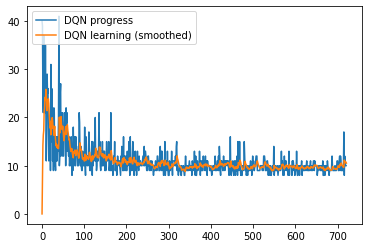

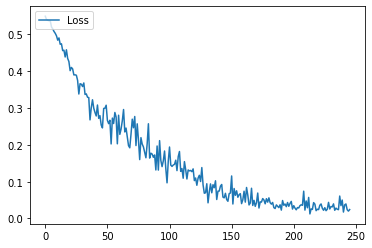

In [45]:
visualize_progress(progress, loss_history)

Let us see how the agent performs across the training:

In [46]:
def record_checkpoint(checkpoint):
  # This function records an episode of the agent equipped with a given chekpoint
  env = gym.make("CartPole-v0")
  model = make_cartpole_network()
  model.set_weights(checkpoint)
  max_ep_len=200
  envw = gym.wrappers.Monitor(env, "./", force=True)
  o, d, ep_len = envw.reset(), False, 0
  while not (d or (ep_len == max_ep_len)):
    envw.render()
    action = choose_best_action(model, o)
    o, r, d, info = envw.step(action)
  envw.close()

Lets take a look at first saved chekpoint:

In [47]:
record_checkpoint(q_checkpoints[0])
file_name = glob.glob('openaigym.video.*.mp4')[0]
show_video(file_name)

And the last:

In [48]:
record_checkpoint(q_checkpoints[-1])
file_name = glob.glob('openaigym.video.*.mp4')[0]
show_video(file_name)

#Ablation study
Let's see the what happens to DQN performance after turning off some of its mechanisms:
- target network
- sampling from replay_buffer

**Exercise: turn off the usage of target networks.** You can for example modify the code of run_dqn() and set target_network = q_network. Compare the results with previous run.

**Exercise: add the size limit to replay buffer.** Add a code to run_dqn() that clips its size to a given limit**. What happens if the replay buffer is very small?

In [49]:
progress2, loss_history2, q_checkpoints2 = run_dqn(8000, 5, False)

Episode = 1 | steps =  17 | episode_length = 17 | epsilon = 0.74625
Episode = 2 | steps =  41 | episode_length = 24 | epsilon = 0.74251875
Episode = 3 | steps =  81 | episode_length = 40 | epsilon = 0.73880615625
Episode = 4 | steps =  107 | episode_length = 26 | epsilon = 0.73511212546875
Episode = 5 | steps =  124 | episode_length = 17 | epsilon = 0.7314365648414063
Episode = 6 | steps =  158 | episode_length = 34 | epsilon = 0.7277793820171993
Episode = 7 | steps =  170 | episode_length = 12 | epsilon = 0.7241404851071133
Episode = 8 | steps =  208 | episode_length = 38 | epsilon = 0.7205197826815777
Episode = 9 | steps =  243 | episode_length = 35 | epsilon = 0.7169171837681698
Episode = 10 | steps =  264 | episode_length = 21 | epsilon = 0.713332597849329
Episode = 11 | steps =  355 | episode_length = 91 | epsilon = 0.7097659348600823
Episode = 12 | steps =  377 | episode_length = 22 | epsilon = 0.706217105185782
Episode = 13 | steps =  425 | episode_length = 48 | epsilon = 0.7026

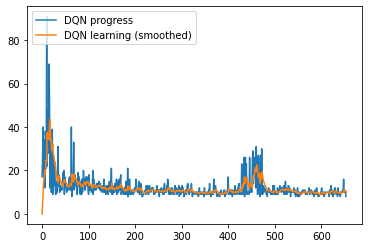

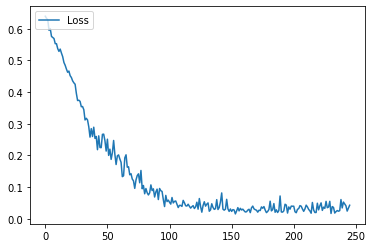

In [50]:
visualize_progress(progress2, loss_history2)

In [52]:
progress3, loss_history3, q_checkpoints3 = run_dqn(8000, 5, True, 1000)

Episode = 1 | steps =  13 | episode_length = 13 | epsilon = 0.74625
Episode = 2 | steps =  30 | episode_length = 17 | epsilon = 0.74251875
Episode = 3 | steps =  45 | episode_length = 15 | epsilon = 0.73880615625
Episode = 4 | steps =  89 | episode_length = 44 | epsilon = 0.73511212546875
Episode = 5 | steps =  108 | episode_length = 19 | epsilon = 0.7314365648414063
Episode = 6 | steps =  119 | episode_length = 11 | epsilon = 0.7277793820171993
Episode = 7 | steps =  146 | episode_length = 27 | epsilon = 0.7241404851071133
Episode = 8 | steps =  176 | episode_length = 30 | epsilon = 0.7205197826815777
Episode = 9 | steps =  192 | episode_length = 16 | epsilon = 0.7169171837681698
Episode = 10 | steps =  210 | episode_length = 18 | epsilon = 0.713332597849329
Episode = 11 | steps =  225 | episode_length = 15 | epsilon = 0.7097659348600823
Episode = 12 | steps =  235 | episode_length = 10 | epsilon = 0.706217105185782
Episode = 13 | steps =  246 | episode_length = 11 | epsilon = 0.70268

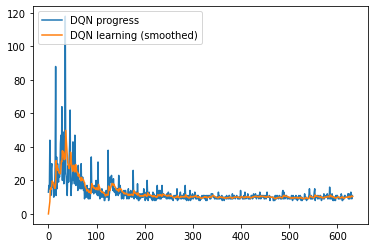

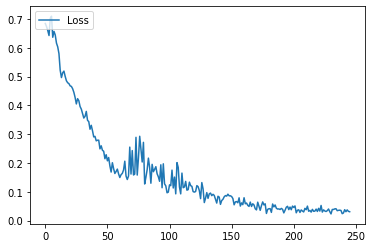

In [53]:
visualize_progress(progress3, loss_history3)